http://blog.naver.com/PostView.nhn?blogId=chrhdhkd&logNo=221470462702&parentCategoryNo=87&categoryNo=&viewDate=&isShowPopularPosts=true&from=search

https://github.com/BoostcampAITech/lecture-note-python-basics-for-ai/tree/main/codes/pytorch/03_cnn/dog_breeds


In [1]:
from torchvision import datasets, transforms

In [2]:
PATH = "/content/drive/MyDrive/pytorch_tutorial/pytorch_tutorial/03_CNN_with_custom_dataset/dataset"



In [11]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [4]:
image_datasets = datasets.ImageFolder(PATH, train_transforms)

In [5]:
print(image_datasets)

Dataset ImageFolder
    Number of datapoints: 927
    Root location: /content/drive/MyDrive/pytorch_tutorial/pytorch_tutorial/03_CNN_with_custom_dataset/dataset
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], resample=False, expand=False)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [6]:
class_names = image_datasets.classes 
print(class_names)

['antman', 'captainamerica', 'hulk', 'ironman', 'spiderman', 'thor']


In [7]:
from torch.utils import data

In [8]:
train_size = int(0.8 * len(image_datasets))
test_size = len(image_datasets) - train_size

In [9]:
train_dataset, test_dataset = data.random_split(image_datasets, [train_size, test_size])

In [10]:
train_loader = data.DataLoader(train_dataset, batch_size = 8, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=8, shuffle=True)

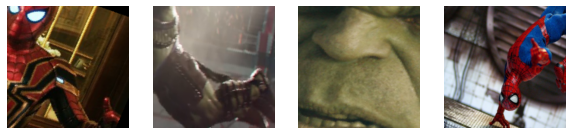

In [20]:
data_iter = iter(test_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)

In [16]:
import matplotlib.pyplot as plt 
import numpy as np 
